## Problems to solve / optimize

1. Lossy waveform <-> spectrogram convesion
- Worst case scenario - let it be as is, resulting in overall bad audio quality for resulting "restored" audio.
- Slightly better idea - don't do anything fundamentally about this problem, just make resulting audio better by applying some post-processing filter to blend result better.
- Possible alternative to mel-spectrogram: using lossless spectrogram transformation with complex numbers from here https://pytorch.org/audio/stable/transforms.html. Problem is, it's in PyTorch and I don't think CNN supports complex values, and even if it does result still may look weird because mel-spectrograms should work way better for ML.
- In theory we should be able to restore mel-spectrograms much better since we have access to original audio (most of it), but I don't see any easy-to-use options for this and implementing all math yourself looks a bit scary, although this is the option with the best potential in my opinion.
- Be crazy and use another ML model to do this inverse transformation better, e.g. this research paper https://arxiv.org/pdf/2208.12782.pdf

2. Mel-spectrogram data is weird and idk how to properly preprocess it for CNN
- Untouched data from mel-spectrogram has values distributed somewhat exponentially, with most of them being near 0 but with some outliers around ~1400, smoothly distributed overall like an exponent
- Because of this MinMaxScaler doesn't produce good results because most values tend to be near 0.0
- StandardScaler works weird too, better then MinMaxScaler in my opinion but it still produces weird results
- Most of those issues come from activation functions within CNN itself, for MinMaxScaler results just look unnatural with linear output, for StandardScaler it looks better but with many noisy black spots due to negative values being present in final predicted spectrogram, when in reality values should be always >=0.
- idk, maybe experiment with different activation functions more, for now relu for everything + linear on final layer is the best, but it produces this weird noise, also silu on everything works somewhat fine but with too much loss for now, but without this weird noise.
- also it's possible that inverse_transform for our scaler doesn't work as intended because of the nature of our data, especially for StandardScaler where it obviously gives some regions warmer color then it should, which may result in bad final performance even though losses are kinda fine. So maybe do something about this.

# Setup

In [1]:
import os
import cv2
import uuid
import utils
import shutil
import joblib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import librosa
import soundfile as sf
import IPython.display as ipd

In [2]:
try:
    shutil.rmtree('tmp')
except:
    pass  
os.makedirs('tmp')

In [2]:
mount_drive = False

if mount_drive:
    from google.colab import drive
    drive.mount('/content/drive')


def get_file_path(path):
    if mount_drive:
        return f"/content/drive/MyDrive/labs/NTZ/Coursework/{path}"
    return path

In [9]:
# Set to some specific value if you want it to be used for every song, otherwise first loaded song will overwrite this with its value
sample_rate = None 

In [8]:
max_tracks = 128

sample_duration = 4

cut_width = 22 # each second is ~44 width units in those spectograms (for n_fft=2048, hop_length=512)

n_fft = 2048
hop_length = 512

random_state = 45100
np.random.seed(random_state)

### Generate extra small dataset if needed

In [13]:
def prep_track_ids(dataset_path='dataset/fma_small'):
    dataset_path = get_file_path(dataset_path)
    tmp = pd.read_csv(get_file_path('dataset/fma_metadata/raw_tracks_id.csv'), sep=',')
    all_track_ids = tmp['track_id'].to_numpy()
    print(all_track_ids[:10], all_track_ids.shape)
    track_ids = []
    for id in all_track_ids:
        filename = utils.get_audio_path(dataset_path, id)
        if os.path.isfile(filename):
            track_ids.append(id)
    track_ids = np.array(track_ids)
    print(track_ids[:10], track_ids.shape)
    return track_ids

# track_ids = prep_track_ids()
# np.random.shuffle(track_ids)
# print(track_ids[:10])

# filenames = [utils.get_audio_path('.\\dataset\\fma_small', track_id) for track_id in track_ids]
# print(filenames[:4])

# def generate_extra_small_dataset(filenames):
#     for filename in filenames:
#         os.makedirs('\\'.join(filename.replace('fma_small', 'fma_extra_small').split('\\')[:-1]), exist_ok=True)
#         shutil.copy(filename, filename.replace('fma_small', 'fma_extra_small'))

# # generate_extra_small_dataset(filenames[:max_tracks])
# filenames = [filename.replace('fma_small', 'fma_extra_small') for filename in filenames]

In [14]:
track_ids = prep_track_ids('dataset/fma_extra_small')
filenames = [get_file_path(utils.get_audio_path('dataset/fma_extra_small', track_id)) for track_id in track_ids]
print(len(filenames), filenames[:4])

[  2   3   5  10  20  26  30  46  48 134] (109727,)
[  897  1649  1685  6368  6517 11261 11775 12521 14736 15210] (128,)
128 ['dataset/fma_extra_small\\000\\000897.mp3', 'dataset/fma_extra_small\\001\\001649.mp3', 'dataset/fma_extra_small\\001\\001685.mp3', 'dataset/fma_extra_small\\006\\006368.mp3']


# Functions

In [8]:
def load_dataset(filenames, sample_rate):
    """
    Returns python list with [num_tracks] numpy array of shape (track_length, 1), track_length may be different for each song.
    """
    dataset = []
    if max_tracks != None:
        filenames = filenames[:max_tracks]
    for filename in tqdm(filenames):
        data, sample_rate = librosa.load(filename, sr=sample_rate)
        data = np.expand_dims(data, axis=-1)
        dataset.append(data)
    return dataset, sample_rate


def sample_dataset(dataset):
    assert sample_rate is not None
    sampled_dataset = []
    sample_length = int(sample_rate * sample_duration)
    for track in dataset:
        for i in range(0, track.shape[0], sample_length):
            sampled_dataset.append(track[i:i+sample_length])
        if sampled_dataset[-1].shape[0] != sample_length:
            sampled_dataset.pop()
    return sampled_dataset


def display_audio_waveform(audio):
    assert sample_rate is not None
    librosa.display.waveshow(audio.reshape(-1), sr=sample_rate)


def write_audio(filename, audio):
    sf.write(filename, audio, sample_rate, 'PCM_24')


def play_audio(audio):
    assert sample_rate is not None
    filename = f'tmp/{uuid.uuid1()}.wav'
    write_audio(filename, audio)
    ipd.display(ipd.Audio(filename, rate=sample_rate))


def scaler_transform(spectrograms):
    global scaler_fitted
    num_samples, width, height, channels = spectrograms.shape
    spectrograms = np.reshape(spectrograms, (num_samples, width * height * channels))
    if scaler_fitted: # type: ignore
        spectrograms = scaler.transform(spectrograms)
    else:
        spectrograms = scaler.fit_transform(spectrograms)
        scaler_fitted = True
    spectrograms = np.reshape(spectrograms, (num_samples, width, height, channels)) # type: ignore
    return spectrograms


def scaler_inverse_transform(spectrograms):
    assert scaler_fitted is True
    num_samples, width, height, channels = spectrograms.shape
    spectrograms = np.reshape(spectrograms, (num_samples, width * height * channels))
    spectrograms = scaler.inverse_transform(spectrograms)
    spectrograms = np.reshape(spectrograms, (num_samples, width, height, channels)) # type: ignore
    return spectrograms

  
def pad_audio(audio, pad):
    pad_for = pad - (audio.shape[0] % pad)
    if pad == pad_for:
        return audio
    return np.expand_dims(np.pad(audio.reshape(-1), (0, pad_for), 'constant', constant_values=(0, 0)), axis=-1)


def get_mel_spectogram(audio):
    assert sample_rate is not None
    padded_audio = pad_audio(audio, pad=n_fft).reshape(-1)
    S = librosa.feature.melspectrogram(y=padded_audio, sr=sample_rate, hop_length=hop_length, n_fft=n_fft)
    S = np.expand_dims(S, axis=-1) # Add channel dimension
    return S


def generate_cut_range(S):
    cut_y_start = int(S.shape[1] * (np.random.rand() * 0.6 + 0.2))
    cut_height = 128 # 128 is the max height (at least for n_fft=2048, hop_length=512)
    return slice(0, cut_height), slice(cut_y_start, cut_y_start+cut_width)


def restore_spectrogram(S_cut, S_pred):
    def get_cut_range(S):
        tmp = S.reshape(S.shape[:-1]).T
        start, end = None, None

        for i, s_col in enumerate(tmp[10:-10]):
            if start == None:
                if np.array_equal(s_col, np.zeros(128)):
                    start = i + 10
            else:
                if not np.array_equal(s_col, np.zeros(128)):
                    end = i + 10
                    break

        return slice(start, end)


    def splice_spectrograms(S_cut, S_pred):
        cut_range = get_cut_range(S_cut)
        S = np.copy(S_cut)
        S[:, cut_range] = S_pred[:, cut_range]
        return S

    tmp_S = splice_spectrograms(S_cut, S_pred)
    cr0 = get_cut_range(S_cut)
    cr = slice(cr0.start - 4, cr0.stop + 4)
    roi = tmp_S[:, cr].copy()
    blurred_roi = cv2.GaussianBlur(roi, (3, 1), 0)
    blurred_roi = cv2.GaussianBlur(blurred_roi, (3, 1), 0)
    blurred_roi = np.expand_dims(blurred_roi, axis=-1)
    blurred_S = tmp_S.copy()
    blurred_S[:, cr] = blurred_roi
    return blurred_S, cr0
    

def cut_spectogram(S):
    S_cut = np.copy(S)
    cut_range = generate_cut_range(S)
    cut_region = np.array(S_cut[cut_range])
    S_cut[cut_range] = 0
    return S_cut, cut_region


def show_waveform(raw_audio):
    assert sample_rate is not None
    librosa.display.waveshow(raw_audio, sr=sample_rate, alpha=0.5, label='Original Audio')


def show_waveform_comparison(raw_audio_og, raw_audio_restored):
    assert sample_rate is not None
    fig, ax = plt.subplots(1, 1)
    librosa.display.waveshow(raw_audio_og, sr=sample_rate, alpha=0.5, ax=ax[0], label='Original Audio')
    librosa.display.waveshow(raw_audio_restored, sr=sample_rate, color='r', alpha=0.5, ax=ax[0], label='Restored Audio')
    ax[0].set(title='Multiple waveforms')
    ax[0].legend()


def show_mel_spectogram(S):
    assert sample_rate is not None
    S_dB = librosa.power_to_db(S.reshape(S.shape[:-1]), ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sample_rate, fmax=8000)
    plt.colorbar(img, format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')


def reconstruct_raw_audio_from_mel_spectogram(S):
    assert sample_rate is not None
    return np.expand_dims(librosa.feature.inverse.mel_to_audio(S.reshape(S.shape[:-1]), sr=sample_rate, n_fft=n_fft, hop_length=hop_length), axis=-1)


In [9]:
def get_cnn_model(input_shape):
    input = keras.layers.Input(shape=input_shape)

    conv1 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)

    conv2 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input)
    conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)

    add1 = keras.layers.Add()([conv1, conv2])

    conv3 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(add1)
    conv3 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)

    conv4 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(add1)
    conv4 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)

    conv5 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(add1)
    
    conv6 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(add1)

    add2 = keras.layers.Add()([conv3, conv4, conv5])

    conv7 = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(add2)

    add3 = keras.layers.Add()([conv7, add2, conv6])

    output = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(add3)
    output = keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(output)

    return keras.Model(inputs=input, outputs=output)

# Experiments

In [10]:
ds, sample_rate = load_dataset(filenames, sample_rate)
len(ds), ds[0].shape, sample_rate

100%|██████████| 128/128 [00:08<00:00, 15.75it/s]


(128, (1321967, 1), 44100)

In [11]:
sample_ds = sample_dataset(ds)
len(sample_ds), sample_ds[0].shape

(896, (176400, 1))

In [12]:
spectrogram_ds = np.array([get_mel_spectogram(sample) for sample in sample_ds])
spectrogram_ds.shape

(896, 128, 349, 1)

In [30]:
CS = [cut_spectogram(S) for S in spectrogram_ds]
X = np.array([S_cut for S_cut, _ in CS])
y = np.copy(spectrogram_ds)

scaler = MinMaxScaler()
scaler_fitted = False

X = scaler_transform(X)
y = scaler_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=random_state)

print(X.shape, y.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(896, 128, 349, 1) (896, 128, 349, 1)
(716, 128, 349, 1) (180, 128, 349, 1) (716, 128, 349, 1) (180, 128, 349, 1)


In [14]:
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [31]:
fit_new_model = False
if fit_new_model:
    cnn_model = get_cnn_model(X.shape[1:])
    cnn_model.compile(optimizer='adam', loss=SSIMLoss)
    history = cnn_model.fit(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)])
    cnn_model.save(get_file_path('models/2'))
    joblib.dump(history, get_file_path('models/history-2.joblib'))
else:
    cnn_model = keras.models.load_model(get_file_path('models/2'), custom_objects={'SSIMLoss': SSIMLoss})

In [32]:
y_pred = cnn_model.predict(X_test)

6/6 [==============================] - 20s 3s/step


In [33]:
y_test = scaler_inverse_transform(y_test)
X_test = scaler_inverse_transform(X_test)
y_pred = scaler_inverse_transform(y_pred)

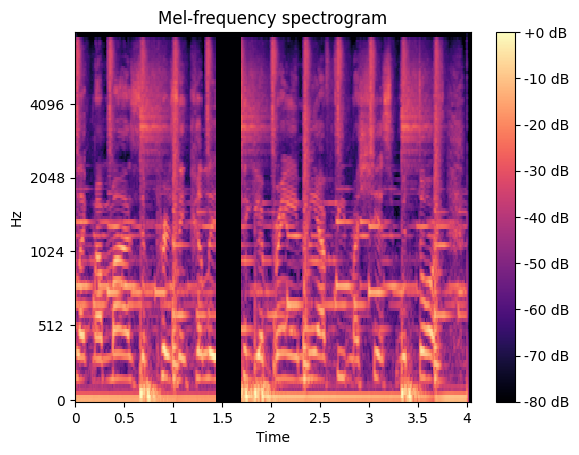

In [34]:
show_mel_spectogram(X_test[0])

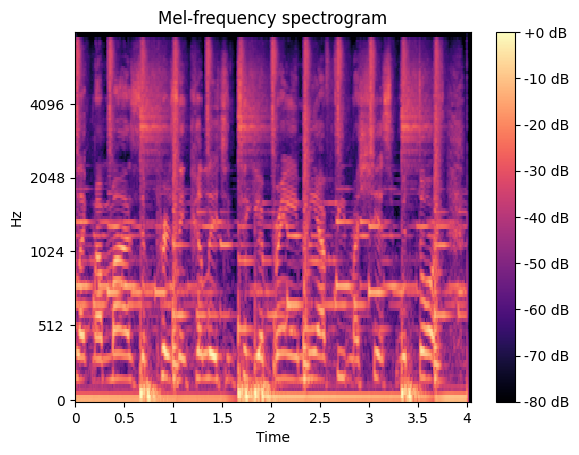

In [35]:
show_mel_spectogram(y_test[0])

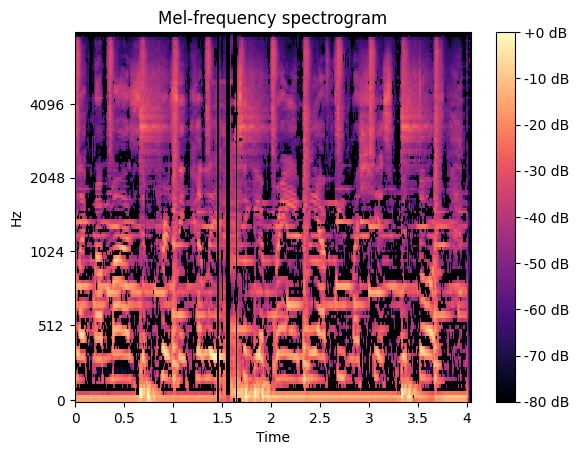

In [36]:
show_mel_spectogram(y_pred[0])

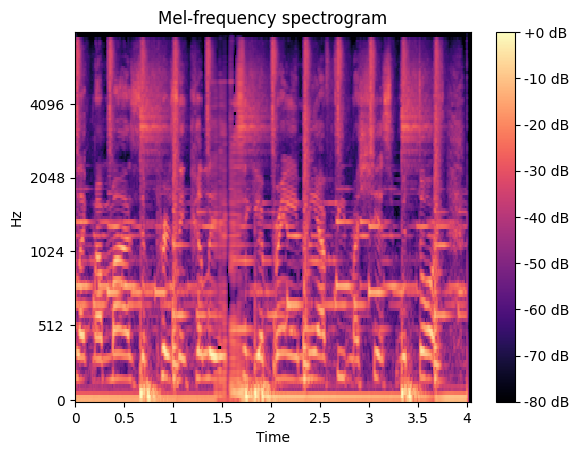

In [37]:
restored_S, cut_range = restore_spectrogram(X_test[0], y_pred[0])
show_mel_spectogram(restored_S)

In [23]:
mel_audio = reconstruct_raw_audio_from_mel_spectogram(y_test[0])
cut_audio = reconstruct_raw_audio_from_mel_spectogram(y_pred[0])
restored_audio = reconstruct_raw_audio_from_mel_spectogram(restored_S)

In [24]:
play_audio(mel_audio)
play_audio(cut_audio)
play_audio(restored_audio)